In [12]:
%pip install segment-anything

import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from sklearn.cluster import DBSCAN
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


In [13]:
# Initialize SAM model
sam_checkpoint = 'sam_vit_h_4b8939.pth'  # Model file in the current directory
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=600
)

Using device: cuda


c:\Users\erand\.conda\envs\gpu_env\lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Image dimensions: (643, 644, 3)
Generating SAM masks...
Initial masks generated: 124
Initial masks generated: 124


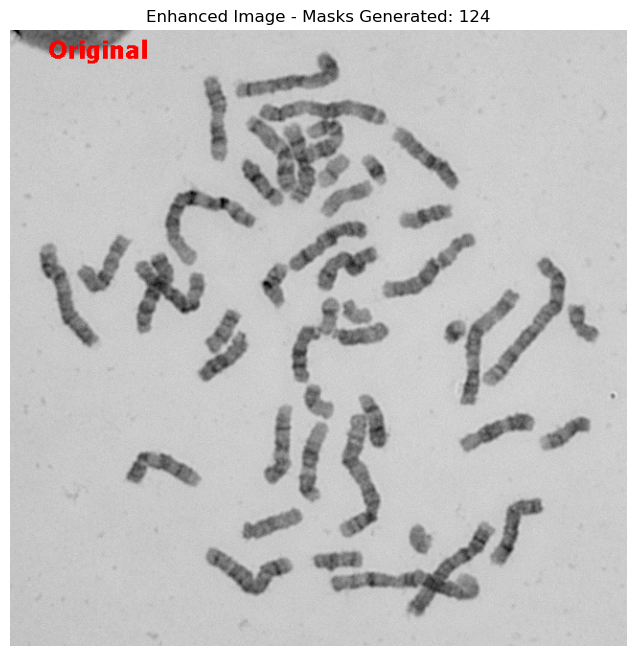

In [16]:
image_path = 'original.tif'  # <-- Update this path
image_bgr = cv2.imread(image_path)

if image_bgr is None:
	print(f"Error: Could not load image from path '{image_path}'. Please check the file path.")
else:
	image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

	pil_img = Image.fromarray(image_rgb)
	enhanced = ImageEnhance.Contrast(pil_img).enhance(1.2)
	enhanced = ImageEnhance.Sharpness(enhanced).enhance(1.1)
	enhanced_image = np.array(enhanced)

	print(f"Image dimensions: {image_rgb.shape}")

	print("Generating SAM masks...")
	masks = mask_generator.generate(enhanced_image)
	print(f"Initial masks generated: {len(masks)}")

	plt.figure(figsize=(8, 8))
	plt.imshow(enhanced_image)
	plt.title(f"Enhanced Image - Masks Generated: {len(masks)}")
	plt.axis('off')
	plt.show()

In [17]:
# Filter masks for chromosomes
filtered_masks = []
for mask in masks:
    area = mask['area']
    bbox = mask['bbox']
    x, y, w, h = bbox
    
    aspect_ratio = max(w/h, h/w) if min(w, h) > 0 else 0
    extent = area / (w * h) if w * h > 0 else 0
    stability = mask['stability_score']
    iou = mask['predicted_iou']
    
    if (800 <= area <= 35000 and
        1.5 <= aspect_ratio <= 10 and
        extent >= 0.3 and
        stability >= 0.85 and
        iou >= 0.85):
        filtered_masks.append(mask)

print(f"Chromosomes after filtering: {len(filtered_masks)}")

Chromosomes after filtering: 26


In [18]:
# Remove duplicates if too many
if len(filtered_masks) > 24:
    centers = []
    for mask in filtered_masks:
        bbox = mask['bbox']
        x, y, w, h = bbox
        centers.append([x + w/2, y + h/2])
    
    centers = np.array(centers)
    clustering = DBSCAN(eps=50, min_samples=1).fit(centers)
    labels = clustering.labels_
    
    unique_masks = []
    for cluster_id in np.unique(labels):
        cluster_indices = np.where(labels == cluster_id)[0]
        
        if len(cluster_indices) == 1:
            unique_masks.append(filtered_masks[cluster_indices[0]])
        else:
            best_idx = cluster_indices[0]
            best_score = filtered_masks[best_idx]['stability_score']
            
            for idx in cluster_indices[1:]:
                if filtered_masks[idx]['stability_score'] > best_score:
                    best_score = filtered_masks[idx]['stability_score']
                    best_idx = idx
            
            unique_masks.append(filtered_masks[best_idx])
    
    filtered_masks = unique_masks

print(f"Final chromosome count: {len(filtered_masks)}")


Final chromosome count: 18


In [22]:
from PIL import Image, ImageEnhance

# ------------------------------
# Enhance and save cropped chromosomes
# ------------------------------
output_dir = 'chromosomes'
os.makedirs(output_dir, exist_ok=True)

cropped_images = []  # list of (filename, image)

for i, mask in enumerate(filtered_masks):
    bbox = mask['bbox']
    x, y, w, h = bbox

    pad = max(5, min(15, int(0.1 * min(w, h))))
    x_start = max(0, x - pad)
    y_start = max(0, y - pad)
    x_end = min(image_rgb.shape[1], x + w + pad)
    y_end = min(image_rgb.shape[0], y + h + pad)

    crop = image_rgb[y_start:y_end, x_start:x_end]

    # --- Enhance image ---
    pil_crop = Image.fromarray(crop)
    # Increase contrast and sharpness
    contrast_enhancer = ImageEnhance.Contrast(pil_crop).enhance(1.3)  
    sharp_enhancer = ImageEnhance.Sharpness(contrast_enhancer).enhance(1.2)
    # Darken slightly (brightness < 1)
    darkened = ImageEnhance.Brightness(sharp_enhancer).enhance(0.9)

    enhanced_crop = np.array(darkened)

    # Save enhanced image
    filename = f"chromosome_{i:03d}.jpg"
    out_path = os.path.join(output_dir, filename)
    cv2.imwrite(out_path, cv2.cvtColor(enhanced_crop, cv2.COLOR_RGB2BGR))

    cropped_images.append((filename, enhanced_crop))


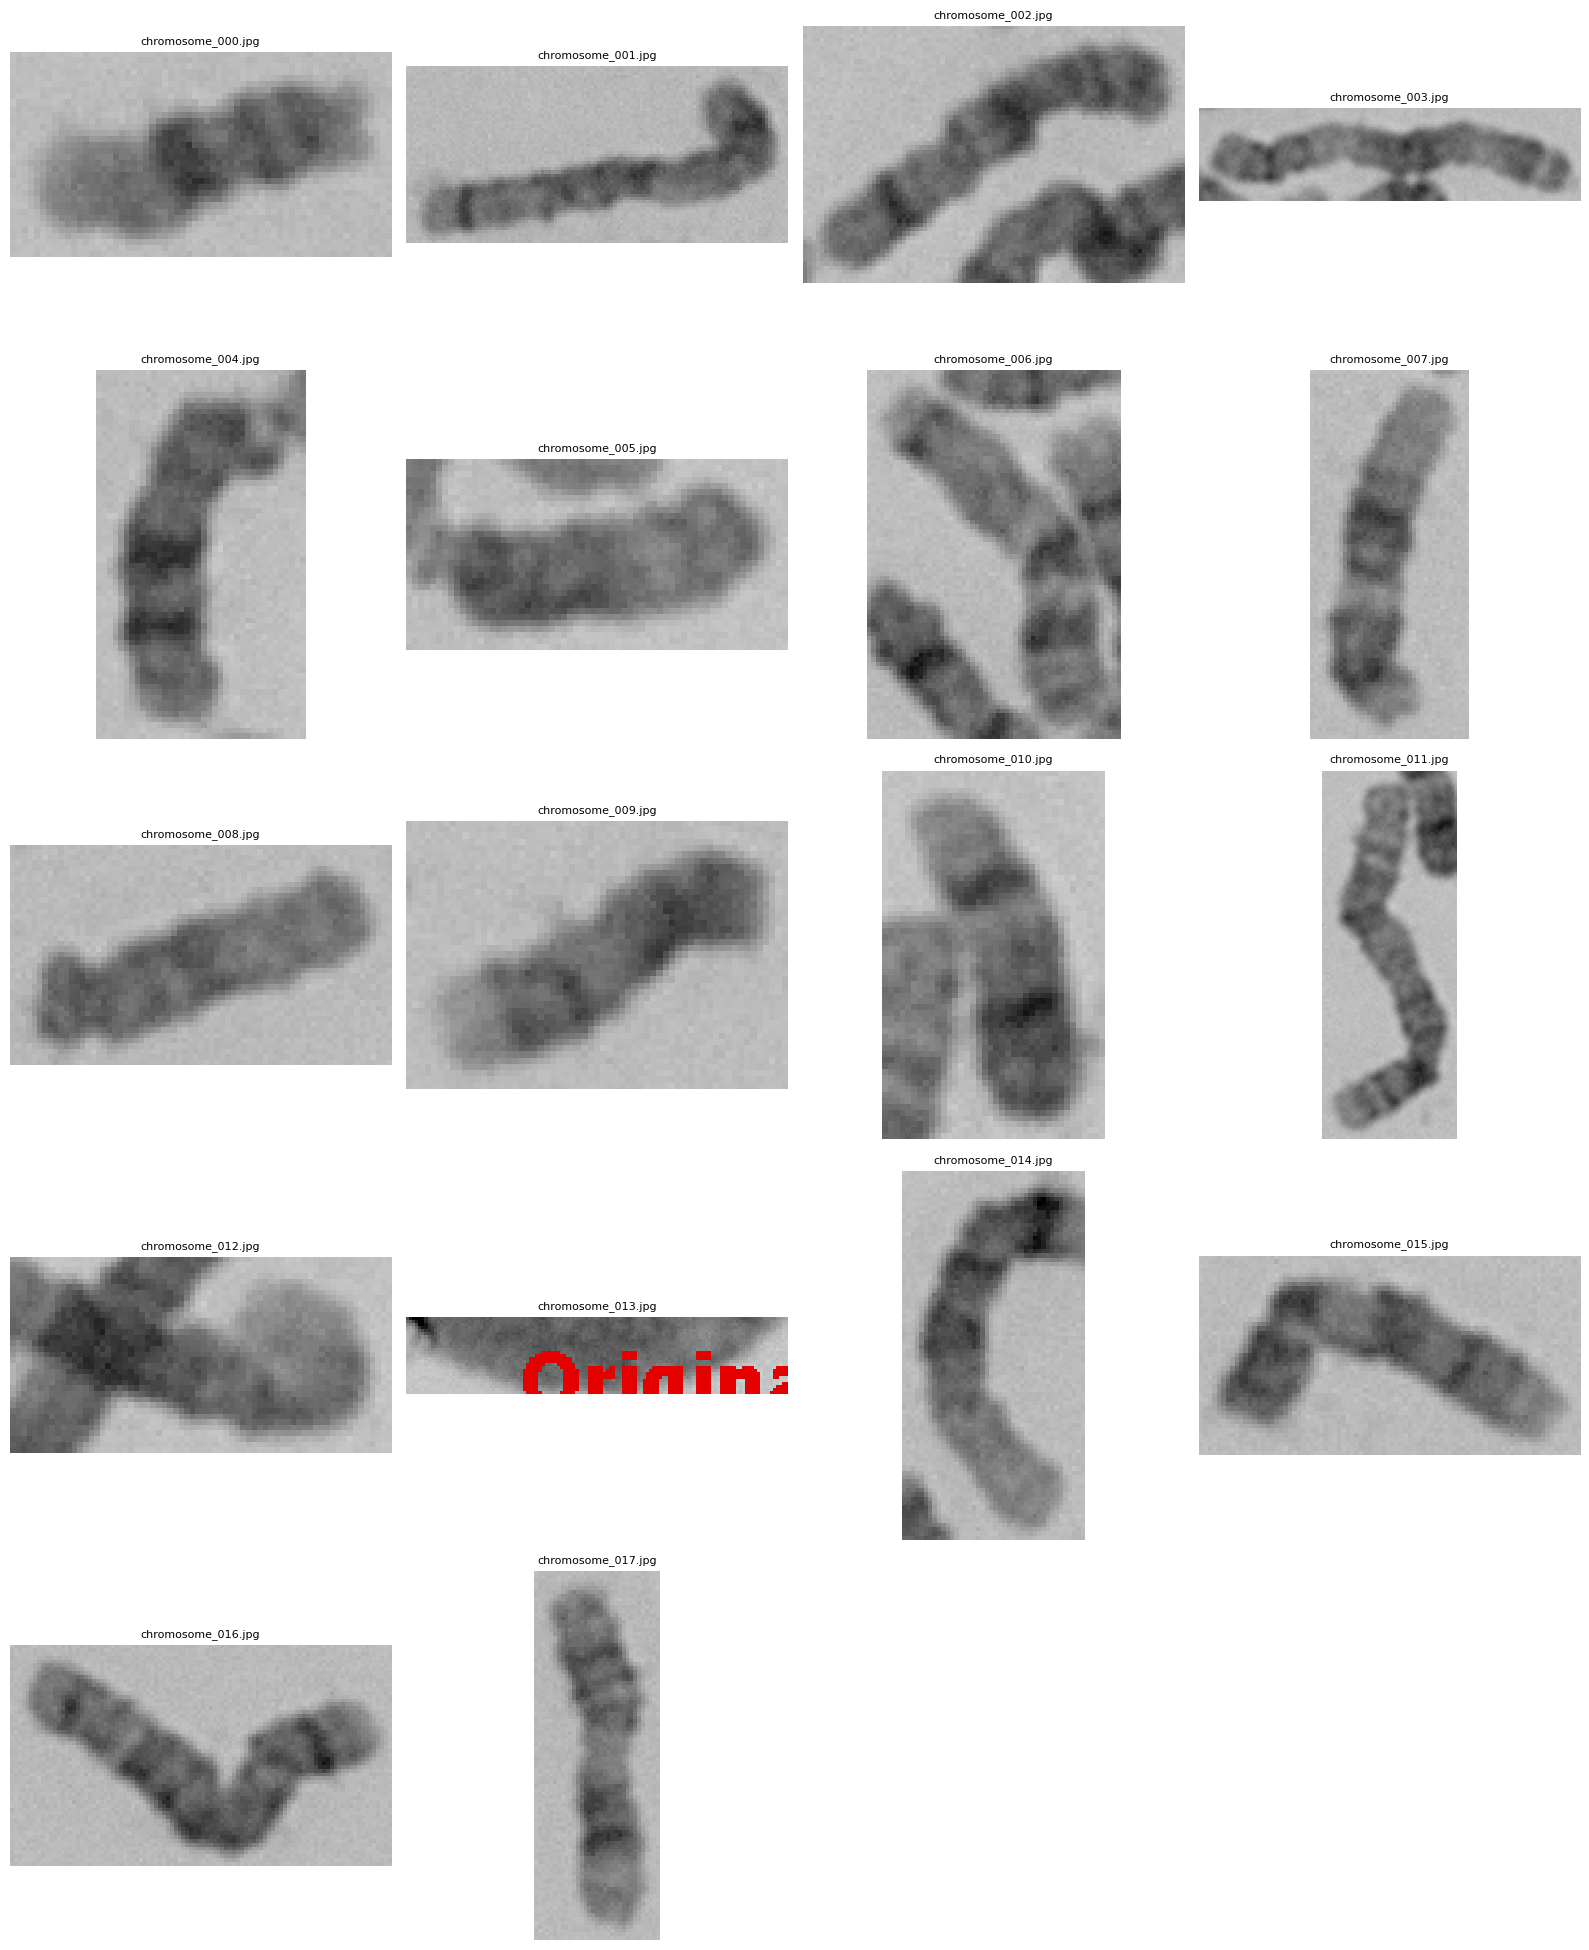

In [23]:
import math

cols = 4
rows = math.ceil(len(cropped_images) / cols)
plt.figure(figsize=(16, rows*4))

for i, (fname, crop) in enumerate(cropped_images):
    plt.subplot(rows, cols, i+1)
    plt.imshow(crop)
    plt.title(fname, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [1]:
import math
import cv2  # for color conversion
import matplotlib.pyplot as plt

cols = 4
rows = math.ceil(len(cropped_images) / cols)
plt.figure(figsize=(16, rows*4))

for i, (fname, crop) in enumerate(cropped_images):
    # Convert to grayscale
    if crop.ndim == 3:  # if RGB
        gray_crop = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
    else:
        gray_crop = crop  # already grayscale

    plt.subplot(rows, cols, i+1)
    plt.imshow(gray_crop, cmap='gray')
    plt.title(fname, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


NameError: name 'cropped_images' is not defined

In [24]:
import shutil

dataset_dir = os.path.join(output_dir, "segment")
os.makedirs(dataset_dir, exist_ok=True)

for fname, crop in cropped_images:
    src = os.path.join(output_dir, fname)
    dst = os.path.join(dataset_dir, fname)
    shutil.copy(src, dst)

print(f"Dataset created at: {dataset_dir}")
print(f"Total images in dataset: {len(cropped_images)}")

Dataset created at: chromosomes\segment
Total images in dataset: 18
